# RFM analysis

This code conducts three different RFM analysis methods (independent RFM, sequential RFM, sequential RFM with a 0.9 confidence interval) on retail transaction data to predict customer's response rate to a campaign.

In [1]:
import pandas as pd
import pyrsm as rsm
import numpy as np
import qgrid
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import datetime as dt

## Read and check the data

In [2]:
response = pd.read_csv("./data/Retail_Data_Response.csv")
trans = pd.read_csv("./data/Retail_Data_Transactions.csv")

In [3]:
response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [4]:
response.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6884 entries, 0 to 6883
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  6884 non-null   object
 1   response     6884 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 107.7+ KB


In [5]:
response.duplicated().sum()

0

In [6]:
trans.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [7]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  125000 non-null  object
 1   trans_date   125000 non-null  object
 2   tran_amount  125000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


In [8]:
trans.duplicated().sum()

6

In [9]:
trans = trans.drop_duplicates()

In [10]:
trans.duplicated().sum()

0

## Pre-processing

In [11]:
trans.trans_date = pd.to_datetime(trans.trans_date, format="%d-%b-%y")
latest_record = trans.trans_date.max()
trans.trans_date = pd.to_timedelta(latest_record - trans.trans_date).dt.days
dat = trans.groupby('customer_id')['trans_date'].agg(recency=min, frequency='count')
dat['monetary'] = trans.groupby('customer_id')['tran_amount'].sum()
dat = dat.reset_index()
dat = pd.merge(dat, response, on = 'customer_id')
dat

,customer_id,recency,frequency,monetary,response
0,CS1112,61,15,1012,0
1,CS1113,35,20,1490,0
2,CS1114,32,19,1432,1
3,CS1115,11,22,1659,1
4,CS1116,203,13,857,1
...,...,...,...,...,...
6879,CS8996,97,13,582,0
6880,CS8997,261,14,543,0
6881,CS8998,84,13,624,0
6882,CS8999,257,12,383,0


## EDA

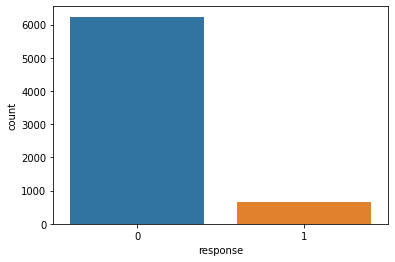

In [12]:
sns.countplot(x='response', data = dat)
plt.show()

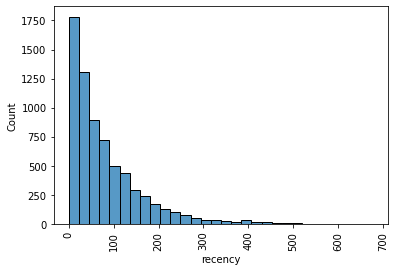

In [13]:
sns.histplot(x='recency', data = dat, bins=30)
plt.xticks(rotation=90)
plt.show()

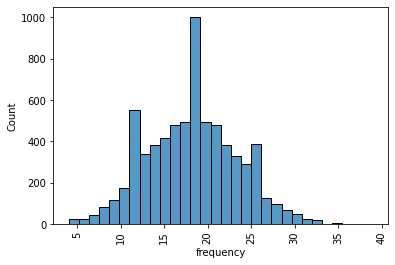

In [14]:
sns.histplot(x='frequency', data = dat, bins=30)
plt.xticks(rotation=90)
plt.show()

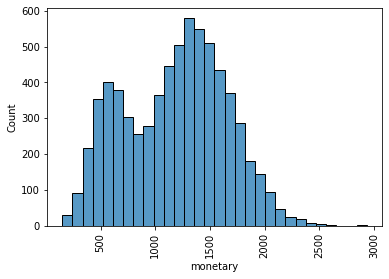

In [15]:
sns.histplot(x='monetary', data = dat, bins=30)
plt.xticks(rotation=90)
plt.show()

In [16]:
dat[['response', 'recency', 'frequency', 'monetary']].corr()

,response,recency,frequency,monetary
response,1.000000,0.023405,0.201285,0.205523
recency,0.023405,1.000000,-0.285936,-0.270078
frequency,0.201285,-0.285936,1.000000,0.934475
monetary,0.205523,-0.270078,0.934475,1.000000


## Baseline

The baseline is to launch campaign randomly. 

In [17]:
dat = dat.assign(p_rnd = np.random.random_sample(dat.shape[0]))

## Generate independent RFM cells

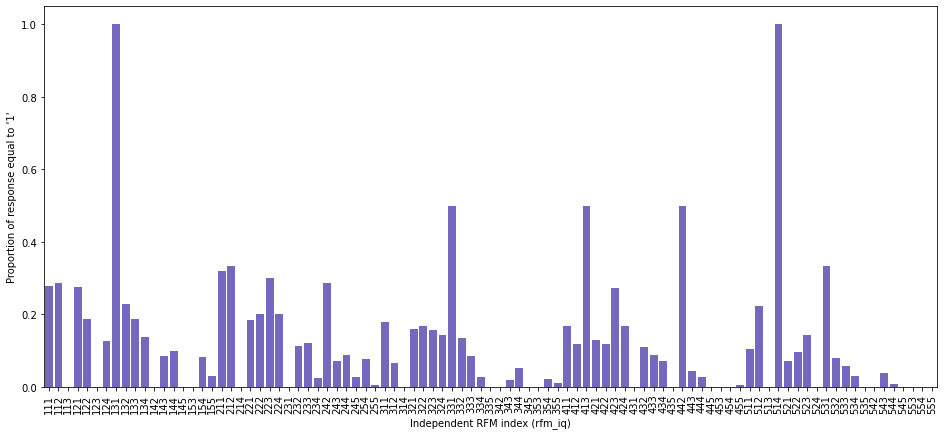

In [18]:
# recency
dat = dat.assign(rec_iq=rsm.xtile(dat["recency"], 5, rev=True))

# frequency
dat = dat.assign(freq_iq=rsm.xtile(dat["frequency"], 5, rev=True))

# monetary
dat = dat.assign(mon_iq=rsm.xtile(dat["monetary"], 5, rev=True))

# rfm_iq
dat = dat.assign(rfm_iq = dat["rec_iq"].astype(str) + dat["freq_iq"].astype(str) + dat["mon_iq"].astype(str))

# Visualization
plt.figure(figsize=(16, 7))
fig = rsm.prop_plot(dat, "rfm_iq", "response", 1)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
fig = fig.set(xlabel="Independent RFM index (rfm_iq)")

## Generate sequential RFM cells

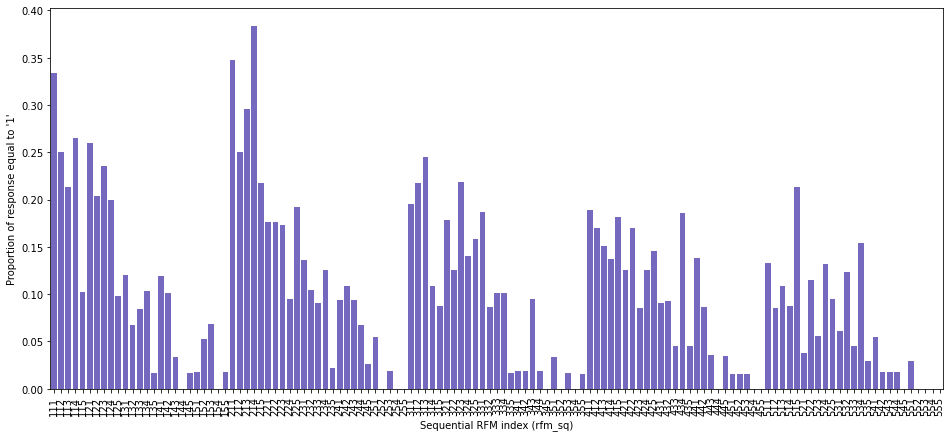

In [19]:
# rec_sq
dat = dat.assign(rec_sq=dat["rec_iq"])

# freq_sq
dat = dat.assign(
    freq_sq=dat.groupby("rec_sq")["frequency"].transform(rsm.xtile, 5, rev=True)
)

# mon_sq
dat = dat.assign(
    mon_sq=dat.groupby(["rec_sq", "freq_sq"])["monetary"].transform(rsm.xtile, 5, rev=True)
)

# rfm_sq
dat = dat.assign(
    rfm_sq=dat["rec_sq"].astype(str)
    + dat["freq_sq"].astype(str)
    + dat["mon_sq"].astype(str)
)

# Visualization
plt.figure(figsize=(16, 7))
fig = rsm.prop_plot(dat, "rfm_sq", "response", 1)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
fig = fig.set(xlabel="Sequential RFM index (rfm_sq)")

## RFM analysis

### Split data

In [20]:
train, test = train_test_split(dat, test_size=0.3, random_state=42, shuffle=True, stratify=dat.response)

The train data is used to select RFM cells which we would like to launch a campaign and the test data set is used to estimate the expected response rate. 

### Break-even 

Calculate the response rate when margin equals to sending cost (break-even). The result is used as the criteria to select our targets. 

#### Assumptions
- The cost of sending a promotion e-mail is \$0.25 per customer.
- The margin (excluding the sending cost) is \$10 per customer.

In [21]:
send_cost = 0.5
margin = 10
breakeven = send_cost/margin
print(f"""The break-even response rate is {round(100*breakeven, 2)}%.""")

The break-even response rate is 5.0%.


### Baseline (randomly)

In [22]:
target_rnd = test[test.p_rnd >= breakeven]
num_offer_rnd = target_rnd.shape[0]
perc_offer_rnd = num_offer_rnd/test.shape[0]
perc_resp_rnd = target_rnd.response.mean()
num_resp_rnd = target_rnd.response.sum()
tot_margin_rnd = num_resp_rnd * margin
tot_send_cost_rnd = num_offer_rnd * send_cost
tot_profit_rnd = tot_margin_rnd - tot_send_cost_rnd
ROME_rnd = tot_profit_rnd/tot_send_cost_rnd
print(
f"""Based on random selection, the number of customers should be sent an offer is {int(num_offer_rnd):,} ({round((100 * perc_offer_rnd), 2)}%).
The response rate for the selected customers is predicted to be {round((100 * perc_resp_rnd), 2)}% or {int(num_resp_rnd):,} buyers.
The revenue is equal to ${int(tot_margin_rnd):,}. The expected profit is ${int(tot_profit_rnd):,}.
The mailing cost is estimated to be ${int(tot_send_cost_rnd):,} with a ROME of {round((100 * ROME_rnd), 2)}%."""    
    )


Based on random selection, the number of customers should be sent an offer is 1,964 (95.06%).
The response rate for the selected customers is predicted to be 9.47% or 186 buyers.
The revenue is equal to $1,860. The expected profit is $878.
The mailing cost is estimated to be $982 with a ROME of 89.41%.


### Independent RFM analysis

In [23]:
# calculate the average response rate within each RFM cells 
# and then select cells with a higher response rate than break-even
def sendto(x, lev=1, breakeven=breakeven):
    return np.nanmean(x == lev) > breakeven

# generate the target list

def gen_list(df=train, method='rfm_iq', send='sendto_iq'):
    return df.loc[df[send], method].unique().tolist()

# estimate the expected performance within the selected group

def perf_calc(df=test, intro='independence RFM analysis', method='rfm_iq', list=[]):
    df = df.assign(sendto = df[method].isin(list))
    
    # number of offers
    perc_offer = np.mean(df['sendto'])
    num_offer = sum(df['sendto'])
    
    # response:
    sendto_group = df[df['sendto']]
    perc_resp = np.mean(sendto_group["response"])
    num_resp = sum(sendto_group["response"])
    
    # total margin
    tot_margin = num_resp * margin

    # total sending cost
    tot_send_cost = num_offer * send_cost

    # total profits
    tot_profit = tot_margin - tot_send_cost

    # ROME
    ROME = tot_profit/tot_send_cost
    
    # automatic print
    print(
f"""Based on {intro}, the number of customers should be sent an offer is {int(num_offer):,} ({round((100 * perc_offer), 2)}%).
The response rate for the selected customers is predicted to be {round((100 * perc_resp), 2)}% or {int(num_resp):,} buyers.
The revenue is equal to ${int(tot_margin):,}. The expected profit is ${int(tot_profit):,}.
The mailing cost is estimated to be ${int(tot_send_cost):,} with a ROME of {round((100 * ROME), 2)}%."""    
    )
    
    return tot_profit, ROME

In [24]:
train = train.assign(sendto_iq = train.groupby('rfm_iq')['response'].transform(sendto))
list_iq = gen_list(df=train, method='rfm_iq', send='sendto_iq')
tot_profit_iq, ROME_iq = perf_calc(df=test, 
                                   intro='independence RFM analysis', 
                                   method='rfm_iq', 
                                   list=list_iq)

Based on independence RFM analysis, the number of customers should be sent an offer is 1,310 (63.41%).
The response rate for the selected customers is predicted to be 12.75% or 167 buyers.
The revenue is equal to $1,670. The expected profit is $1,015.
The mailing cost is estimated to be $655 with a ROME of 154.96%.


### Sequential RFM analysis

In [25]:
train = train.assign(sendto_sq = train.groupby('rfm_sq')['response'].transform(sendto))
list_sq = gen_list(df=train, method='rfm_sq', send='sendto_sq')
tot_profit_sq, ROME_sq = perf_calc(df=test, 
                                   intro='sequential RFM analysis', 
                                   method='rfm_sq', 
                                   list=list_sq)

Based on sequential RFM analysis, the number of customers should be sent an offer is 1,250 (60.5%).
The response rate for the selected customers is predicted to be 13.44% or 168 buyers.
The revenue is equal to $1,680. The expected profit is $1,055.
The mailing cost is estimated to be $625 with a ROME of 168.8%.


### Sequential RFM analysis with a 0.9 confidence interval 

For this approach, we used the lower bond of each sequential RFM cell's average response rate with a 0.9 confidence interval and compared the results to break-even response rate. This method considered as a more conservative way with a lower expected profit and a higher ROME.

In [26]:
def sendto_lb(x, lev=1, breakeven=breakeven):
    x = x == lev
    return (np.nanmean(x) - 1.64 * np.std(x)/np.sqrt(x.shape[0])) > breakeven

train = train.assign(sendto_sqlb = train.groupby('rfm_sq')['response'].transform(sendto_lb))
list_sqlb = gen_list(df=train, method='rfm_sq', send='sendto_sqlb')
tot_profit_sqlb, ROME_sqlb = perf_calc(df=test, 
                                   intro='sequential RFM analysis with a 0.9 confidence interval', 
                                   method='rfm_sq', 
                                   list=list_sqlb)

Based on sequential RFM analysis with a 0.9 confidence interval, the number of customers should be sent an offer is 563 (27.25%).
The response rate for the selected customers is predicted to be 17.05% or 96 buyers.
The revenue is equal to $960. The expected profit is $678.
The mailing cost is estimated to be $281 with a ROME of 241.03%.


### Comparison

In [27]:
performances = pd.DataFrame({
    "RFM": ["random", "independent", "sequential", "sequential_lb"],
    "Profit":[tot_profit_rnd, tot_profit_iq, tot_profit_sq, tot_profit_sqlb],
    "ROME": [ROME_rnd, ROME_iq, ROME_sq, ROME_sqlb]
})
performances

,RFM,Profit,ROME
0,random,878.0,0.894094
1,independent,1015.0,1.549618
2,sequential,1055.0,1.688000
3,sequential_lb,678.5,2.410302


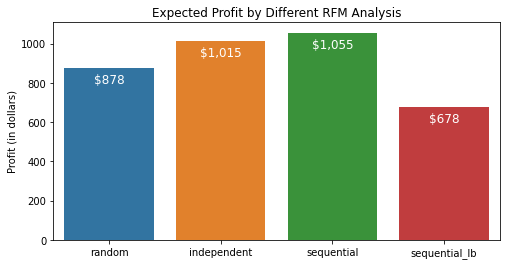

In [28]:
# profit
plt.figure(figsize=(8, 4))
fig = sns.barplot(x="RFM", y="Profit", data=performances, ci=None)
fig.set(xlabel="", ylabel="Profit (in dollars)", title="Expected Profit by Different RFM Analysis")
for index, row in performances.iterrows():
    fig.text(
        index, row.Profit - 80, f"${int(row.Profit):,}", ha="center", color="white", fontsize='large'
    )

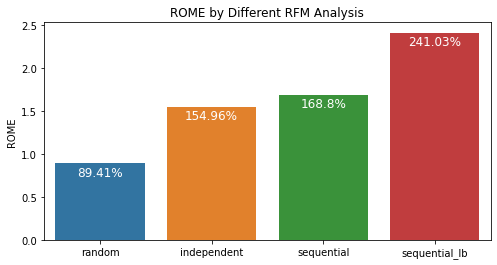

In [29]:
# ROME
plt.figure(figsize=(8, 4))
fig = sns.barplot(x="RFM", y="ROME", data=performances, ci=None)
fig.set(xlabel="", ylabel="ROME", title="ROME by Different RFM Analysis")
for index, row in performances.iterrows():
    fig.text(
        index, row.ROME - 0.15, f"{round(100*row.ROME, 2)}%", ha="center", color="white", fontsize='large'
    )

## Conslusion

Sequential RFM analysis could maximize profit, while the highest return on marketing expenditures(ROME) was achieved by sequential RFM analysis using the lower bonds of 0.9 confidence interval. 

Therefore, from the perspective of company's total profit, we should choose sequential RFM analysis. However, considering the risk and ROME, as well as opportunity cost, using a lower bond can also be a good approach.